In [3]:
!nvidia-smi

Mon Aug 23 01:07:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.63       Driver Version: 466.63       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |    533MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
import numpy as np


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""

    desired_depth = 64
    desired_width = 128
    desired_height = 128

    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume


CN_scan_paths = [
    os.path.join(os.getcwd(), "./test_repo/data/CN", x)
    for x in os.listdir("./test_repo/data/CN")
]

AD_scan_paths = [
    os.path.join(os.getcwd(), "./test_repo/data/AD", x)
    for x in os.listdir("./test_repo/data/AD")
]

print("CN scans: " + str(len(CN_scan_paths)))
print("AD scans: " + str(len(AD_scan_paths)))


FileNotFoundError: [WinError 3] The system cannot find the path specified: './test_repo/data/CN'

In [16]:
AD_scans = np.array([process_scan(path) for path in AD_scan_paths])
CN_scans = np.array([process_scan(path) for path in CN_scan_paths])

AD_labels = np.array([1 for _ in range(len(AD_scans))])
CN_labels = np.array([0 for _ in range(len(CN_scans))])

x_train = np.concatenate((AD_scans[:27], CN_scans[:23]), axis=0)
y_train = np.concatenate((AD_labels[:27], CN_labels[:23]), axis=0)
x_val = np.concatenate((AD_scans[27:], CN_scans[23:]), axis=0)
y_val = np.concatenate((AD_labels[27:], CN_labels[23:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 50 and 50.


In [5]:
import matplotlib.pyplot as plt
import cProfile
tf.executing_eagerly()


train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)



data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


NameError: name 'x_train' is not defined

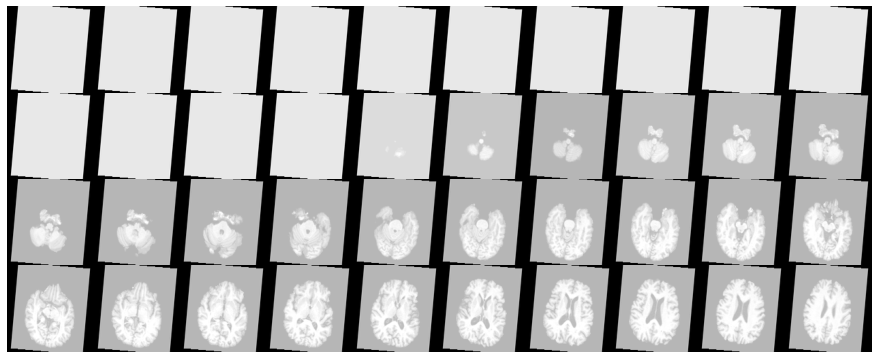

In [18]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional import MaxPooling3D
from keras.layers.convolutional import AveragePooling3D

from tensorflow.keras.layers import BatchNormalization

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model



# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 14, 64)    256   

In [24]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

    
model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10,
        batch_size=20
    )


Epoch 1/10
25/25 [==============================] - 558s 22s/step - loss: 0.6018 - acc: 0.5825 - val_loss: 0.7127 - val_acc: 0.5600
Epoch 2/10
25/25 [==============================] - 563s 23s/step - loss: 0.5746 - acc: 0.6704 - val_loss: 0.7776 - val_acc: 0.5400
Epoch 3/10
25/25 [==============================] - 558s 22s/step - loss: 0.5832 - acc: 0.6816 - val_loss: 0.8021 - val_acc: 0.5400
Epoch 4/10
25/25 [==============================] - 559s 22s/step - loss: 0.6387 - acc: 0.6331 - val_loss: 0.8747 - val_acc: 0.5400
Epoch 5/10
25/25 [==============================] - 547s 22s/step - loss: 0.5229 - acc: 0.7390 - val_loss: 0.7479 - val_acc: 0.5400
Epoch 6/10
25/25 [==============================] - 556s 22s/step - loss: 0.5918 - acc: 0.6257 - val_loss: 0.7321 - val_acc: 0.5000
Epoch 7/10
25/25 [==============================] - 581s 23s/step - loss: 0.6211 - acc: 0.5517 - val_loss: 1.0105 - val_acc: 0.5400
Epoch 8/10
25/25 [==============================] - 596s 24s/step - loss: 0.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib 

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())



Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16294018582453339968
]


NameError: name 'model' is not defined

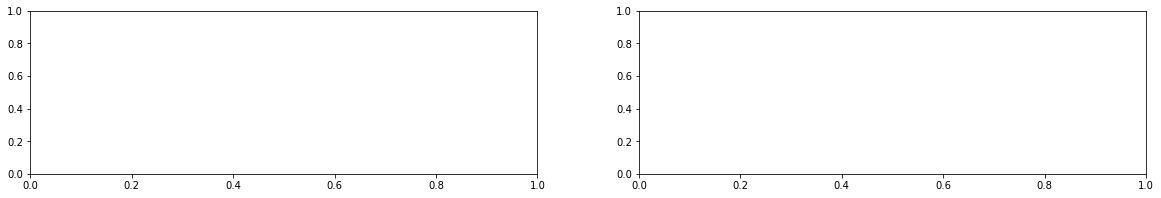

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [4]:
# Load best weights.
model.load_weights("C:/Users/Potato/Documents/ADNI/Train/CN")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )


ValueError: invalid literal for int() with base 10: 'C:\\Users\\Potato\\AppData\\Roaming\\jupyter\\runtime\\kernel-987c58d2-66ba-44b9-b7c4-b299d8fba637.json'